In [1]:
from os import path

import random
import numpy as np

import torch
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

import matplotlib.pyplot as plt

import dataloaders
import networks.utils as utils
import networks.wdcgan_gp as wdcgan

### Setup CUDA / Multiprocessing related variables

In [2]:
USE_CUDA = True

if USE_CUDA and torch.cuda.is_available():
    device = 'cuda' #alt: "cuda:0"
else:
    device = 'cpu'

PIN_MEMORY = True
USE_MULTI_PROCESS_DATA_LOADING = True
# Multi Process Data Loading
if USE_MULTI_PROCESS_DATA_LOADING:
    NUM_THREATS = torch.get_num_threads()
    print("Number of Threats: ", NUM_THREATS)
else:
    NUM_THREATS = 0
    print("Not using Multi-Process Data Loading.")

Number of Threats:  8


### Setup Parameters

In [3]:
SEED = 0
random.seed(SEED)
torch.manual_seed(SEED);

In [4]:
### Data
DATA_PATH = path.join("data","tmdb-64")
TABLE_PATH = path.join("data","tmdb-movies-220915-clean.pkl")

### Architecture
IMAGE_SIZE = 64
IMAGE_SIZE_RATIO = 3 # height/width
NUM_IMG_CHANNELS = 3
NUM_NOISE_VEC_CHANNELS = 100
BASE_NUM_OUT_CHANNELS_G = 64
BASE_NUM_OUT_CHANNELS_D = 64
D_NORM_LAYER_TYPE = "instance" # "none", "spectral", "instance", "layer"
PADDING_MODE = "reflect"
COLORMODE="RGB"

### Training
BATCH_SIZE = 64
NUM_EPOCHS = 21
LEARNING_RATE = 0.0001
BETA1 = 0.5 #default 0.
BETA2 = 0.999 #default 0.9
N_CRITIC = 5 #default 5
LAMBDA_GP = 10 #default 10

### Visualization
NUM_SAMPLES = 64

### Saving
OUT_PATH = path.join("output-runs","wdcgan-output")
SAVE_MODEL_EVERY_N_EPOCHS = 10
SAVE_FAKES_EVERY_N_EPOCHS = 5

### Load dataset

In [5]:
# Poster subset:
GENRE=['Horror']
GENRE_LOGIC='and'
OG_LANG=None
YEAR=None
RUNTIME=(40, np.inf)
MAX_NUM=None
SORT=None

# define dataset
poster_dataset = dataloaders.PosterDataset(table_path=TABLE_PATH, img_root_path=DATA_PATH,
                                    img_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]),
                                    colormode=COLORMODE,
                                    img_in_ram=False,
                                    genre=GENRE, genre_logic=GENRE_LOGIC, og_lang=OG_LANG, year=YEAR, runtime=RUNTIME,
                                    max_num=MAX_NUM, sort=SORT)
posterloader = torch.utils.data.DataLoader(poster_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_THREATS, pin_memory=True)

Sample dataset:

The dataset has 18119 entries.


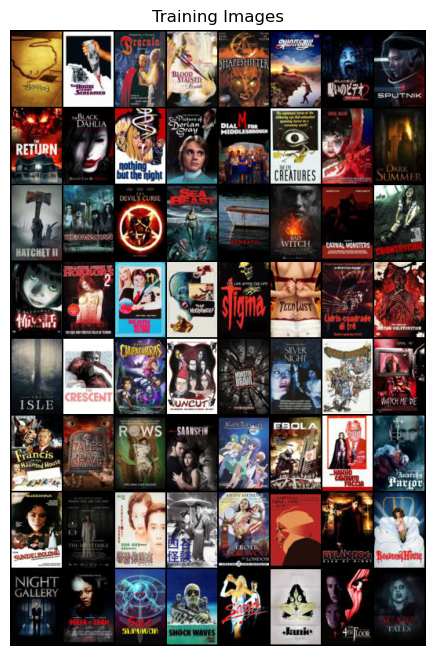

In [6]:
sample_reals = utils.sample_posters(posterloader, number_of_samples=NUM_SAMPLES, colormode=COLORMODE, device=device)
print('The dataset has ' + str(len(poster_dataset)) + ' entries.');

### Initialize Network

In [7]:
generator, discriminator = wdcgan.create_gan(num_img_channels=NUM_IMG_CHANNELS, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, base_num_out_channels_g=BASE_NUM_OUT_CHANNELS_G, base_num_out_channels_d=BASE_NUM_OUT_CHANNELS_D, d_norm_layer_type=D_NORM_LAYER_TYPE, padding_mode=PADDING_MODE, device=device)

print("Generator:")
summary(generator, input_size=(NUM_NOISE_VEC_CHANNELS, 1, 1))
print("\nDiscriminator:")
summary(discriminator, input_size=(3, 96, 64))

Generator:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14        

In [8]:
trainer = wdcgan.create_trainer(out_dir=OUT_PATH, num_samples=NUM_SAMPLES, colormode=COLORMODE, num_noise_vec_channels=NUM_NOISE_VEC_CHANNELS, image_size_ratio=IMAGE_SIZE_RATIO, d_params=discriminator.parameters(), g_params=generator.parameters(), learning_rate=LEARNING_RATE, beta1=BETA1, beta2=BETA2, n_critic=N_CRITIC, lambda_gp=LAMBDA_GP, device=device)

## Train

[0/20]	Loss_D: -48.9998	Loss_G: 96.0544	D(x): 10.1354	D(G(z)): -38.8645 / -96.0544: 100%|██████████| 284/284 [00:26<00:00, 10.74it/s]  


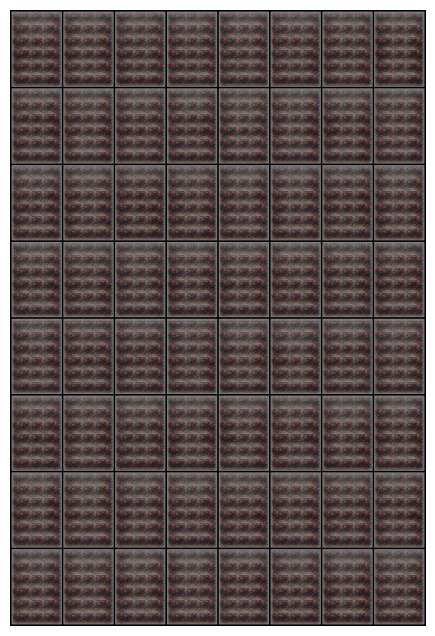

[1/20]	Loss_D: -50.7179	Loss_G: 45.0857	D(x): 8.7501	D(G(z)): -41.9677 / -45.0857: 100%|██████████| 284/284 [00:25<00:00, 10.93it/s]     
[2/20]	Loss_D: -8.1039	Loss_G: -46.4528	D(x): 55.8685	D(G(z)): 47.7647 / 46.4528: 100%|██████████| 284/284 [00:26<00:00, 10.76it/s]  
[3/20]	Loss_D: -16.1958	Loss_G: -1.0862	D(x): 17.1340	D(G(z)): 0.9382 / 1.0862: 100%|██████████| 284/284 [00:26<00:00, 10.87it/s]   
[4/20]	Loss_D: -26.5318	Loss_G: -1.8922	D(x): 28.4183	D(G(z)): 1.8866 / 1.8922: 100%|██████████| 284/284 [00:26<00:00, 10.81it/s]
[5/20]	Loss_D: -20.6574	Loss_G: -1.6984	D(x): 22.1771	D(G(z)): 1.5197 / 1.6984: 100%|██████████| 284/284 [00:25<00:00, 11.01it/s]


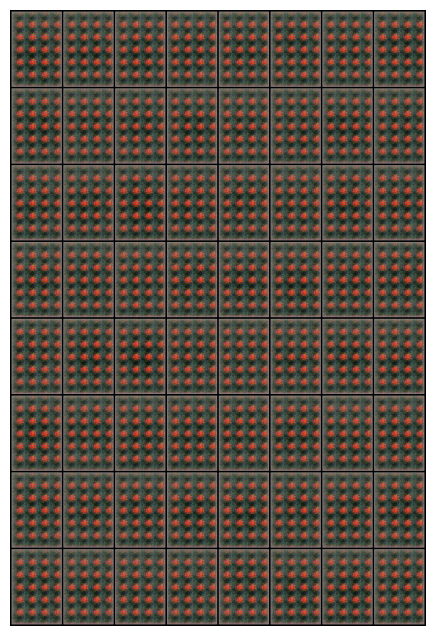

[6/20]	Loss_D: -21.7641	Loss_G: -2.0785	D(x): 23.8945	D(G(z)): 2.1304 / 2.0785: 100%|██████████| 284/284 [00:25<00:00, 10.95it/s]
[7/20]	Loss_D: -17.0710	Loss_G: -4.5658	D(x): 21.7143	D(G(z)): 4.6432 / 4.5658: 100%|██████████| 284/284 [00:26<00:00, 10.69it/s]
[8/20]	Loss_D: -15.1333	Loss_G: -3.1607	D(x): 18.0480	D(G(z)): 2.9147 / 3.1607: 100%|██████████| 284/284 [00:26<00:00, 10.73it/s]   
[9/20]	Loss_D: -13.2862	Loss_G: -25.7596	D(x): 37.4793	D(G(z)): 24.1932 / 25.7596: 100%|██████████| 284/284 [00:26<00:00, 10.83it/s]
[10/20]	Loss_D: -12.6100	Loss_G: -10.4936	D(x): 22.8040	D(G(z)): 10.1940 / 10.4936: 100%|██████████| 284/284 [00:26<00:00, 10.77it/s]


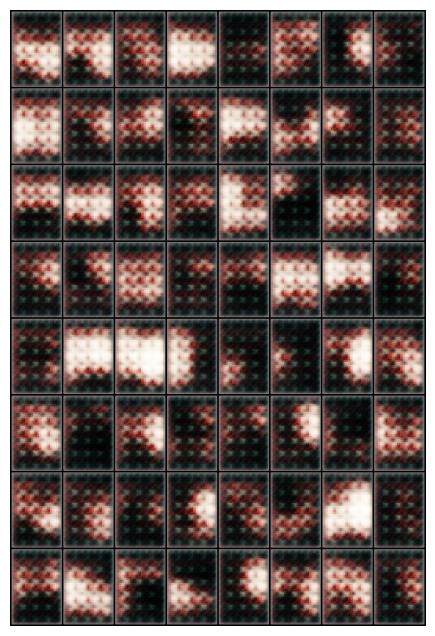

[11/20]	Loss_D: -5.6896	Loss_G: -28.0432	D(x): 35.8977	D(G(z)): 30.2081 / 28.0432: 100%|██████████| 284/284 [00:25<00:00, 10.96it/s]       
[12/20]	Loss_D: -9.7864	Loss_G: -6.5651	D(x): 15.9933	D(G(z)): 6.2069 / 6.5651: 100%|██████████| 284/284 [00:26<00:00, 10.71it/s]    
[13/20]	Loss_D: -12.3308	Loss_G: -43.0740	D(x): 55.9490	D(G(z)): 43.6182 / 43.0740: 100%|██████████| 284/284 [00:25<00:00, 10.96it/s]       
[14/20]	Loss_D: -92.8715	Loss_G: 126.5937	D(x): -73.8006	D(G(z)): -166.6721 / -126.5937: 100%|██████████| 284/284 [00:26<00:00, 10.85it/s]
[15/20]	Loss_D: -13.3365	Loss_G: -7.0870	D(x): 19.7990	D(G(z)): 6.4625 / 7.0870: 100%|██████████| 284/284 [00:25<00:00, 10.94it/s]        


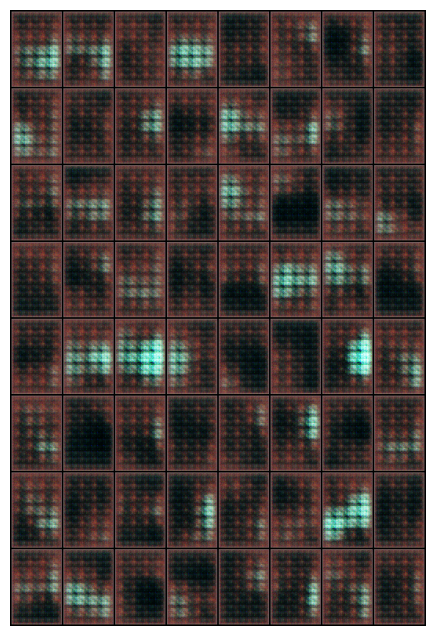

[16/20]	Loss_D: -10.4295	Loss_G: -16.6363	D(x): 27.7296	D(G(z)): 17.3001 / 16.6363: 100%|██████████| 284/284 [00:26<00:00, 10.81it/s]
[17/20]	Loss_D: -10.8990	Loss_G: -8.1404	D(x): 19.8156	D(G(z)): 8.9167 / 8.1404: 100%|██████████| 284/284 [00:26<00:00, 10.78it/s]   
[18/20]	Loss_D: -12.8878	Loss_G: -7.5099	D(x): 20.2719	D(G(z)): 7.3842 / 7.5099: 100%|██████████| 284/284 [00:26<00:00, 10.83it/s]   
[19/20]	Loss_D: -16.4856	Loss_G: -63.8604	D(x): 86.5901	D(G(z)): 70.1045 / 63.8604: 100%|██████████| 284/284 [00:26<00:00, 10.91it/s]       
[20/20]	Loss_D: -13.6906	Loss_G: -27.6042	D(x): 39.8978	D(G(z)): 26.2071 / 27.6042: 100%|██████████| 284/284 [00:26<00:00, 10.85it/s]


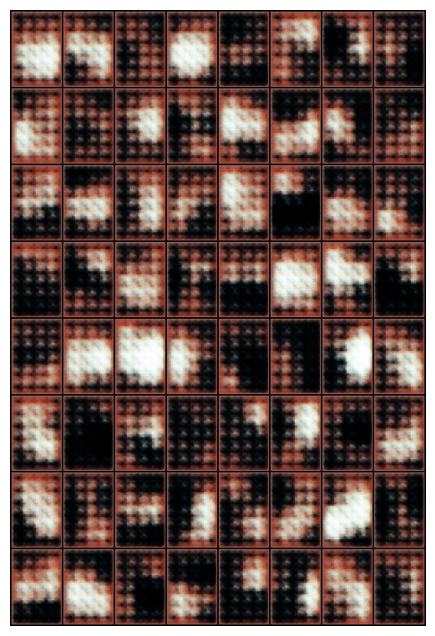

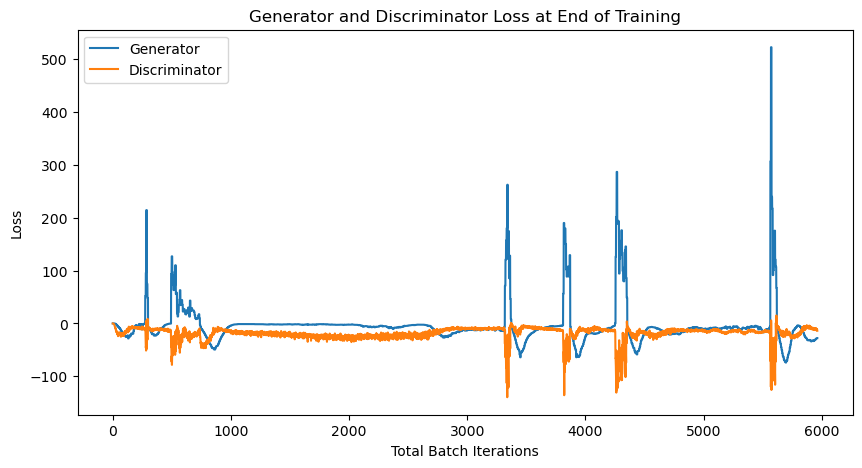

In [9]:
SHOW_GRAPHS = True

trainer.train(generator, discriminator, dataloader=posterloader, num_epochs=NUM_EPOCHS, device=device, fake_img_snap=SAVE_FAKES_EVERY_N_EPOCHS, model_snap=SAVE_MODEL_EVERY_N_EPOCHS, show_graphs=SHOW_GRAPHS)

### Show results

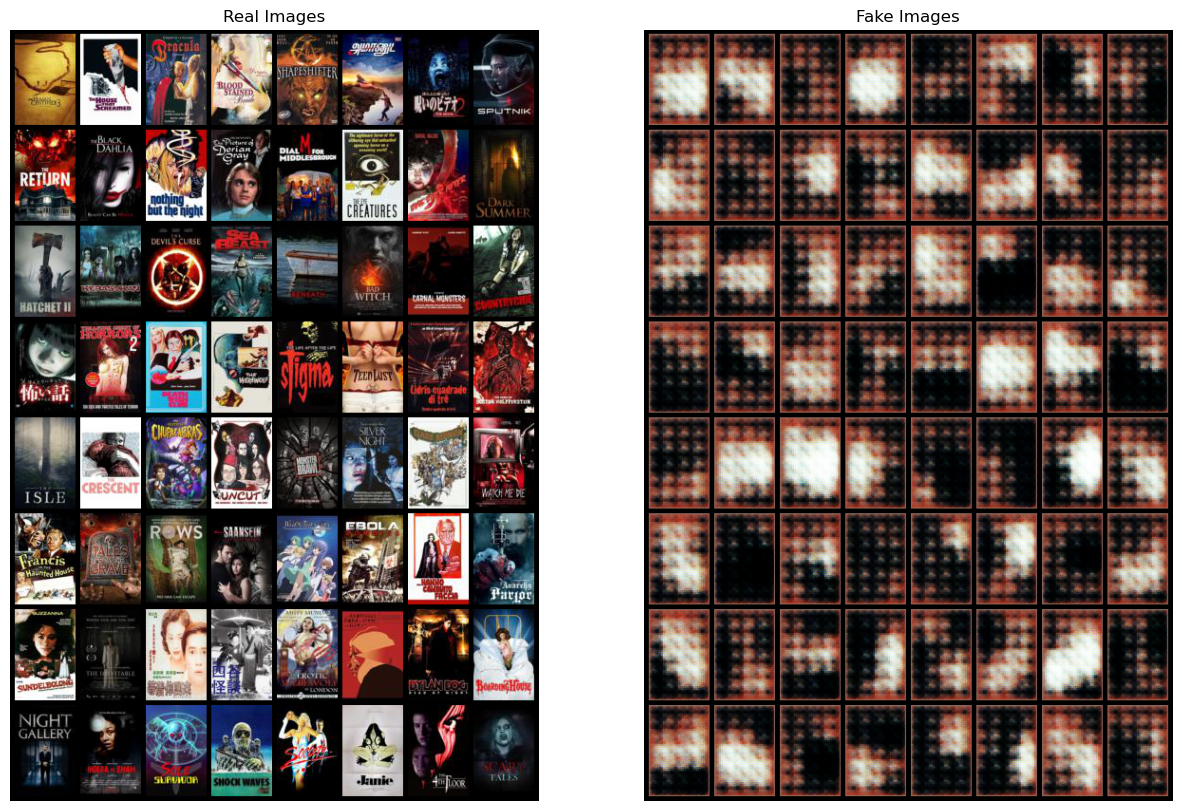

In [10]:
with torch.no_grad():
    sample_fakes = generator(trainer.noise_samples).detach().cpu()
sample_fakes = vutils.make_grid(sample_fakes, padding=5, normalize=True)

fig = plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(sample_reals[0].to(device)[:NUM_SAMPLES], padding=5, normalize=True).cpu(), (1, 2, 0)))

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(sample_fakes, (1, 2, 0)))
plt.show()

fig.savefig(path.join(trainer.last_out_dir, "real_vs_fake.png"))